In [39]:
%pdb on
import matplotlib.pyplot as plt
import gym
env = gym.make('ALE/MsPacman-v5', obs_type='grayscale')
env.reset()

Automatic pdb calling has been turned ON


C:\Users\DeadScholar\miniconda3\lib\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (210, 160)
  logger.warn(


(array([[  0,   0,   0, ...,   0,   0,   0],
        [146, 146, 146, ..., 146, 146, 146],
        [146, 146, 146, ..., 146, 146, 146],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8),
 {'lives': 3, 'episode_frame_number': 0, 'frame_number': 0})

In [7]:
print(env.action_space)
print(env.observation_space)
print(env.reward_range)

Discrete(9)
Box(0, 255, (210, 160), uint8)
(-inf, inf)


## Define the environment

In [116]:
from typing import Optional
import gym
from gym import spaces
import pygame
import numpy as np
import warnings

# References: https://www.gymlibrary.dev/content/environment_creation/
# https://github.com/deepmind/bsuite/blob/main/bsuite/environments/deep_sea.py

class DeepSeaEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}
    
    def __init__(self,
                 size: int,
                 deterministic: bool = True,
                 unscaled_move_cost: float = 0.01,
                 randomize_actions: bool = True,
                 seed: Optional[int] = None,
                 mapping_seed: Optional[int] = None,
                 render_mode=None):
        """Deep sea environment to test for deep exploration.
        Args:
          size: The size of `N` for the N x N grid of states.
          deterministic: Whether transitions are deterministic (default) or 'windy',
            i.e. the `right` action fails with probability 1/N.
          unscaled_move_cost: The total cost for always moving right (no discounting).
            The default (0.01) means the optimal policy gets 0.99 per episode.
          randomize_actions: The definition of DeepSea environment includes random
            mappings of actions: (0,1) -> (left, right) by state. For debugging
            purposes, we include the option to turn this randomization off and
            let 0=left, 1=right in every state.
          seed: Random seed for rewards and transitions, if applicable.
          mapping_seed: Random seed for action mapping, if applicable.
        """
        super().__init__()
        self._size = size
        self._deterministic = deterministic
        self._rng = np.random.RandomState(seed)
        
        # observation (x, y) is the agent's location.
        self.observation_space = spaces.Tuple((spaces.Discrete(size), spaces.Discrete(size)))

        # 2 possible actions {0, 1}.
        self.action_space = spaces.Discrete(2)

        if randomize_actions:
            # Initialize the random mapping.
            self._mapping_rng = np.random.RandomState(mapping_seed)
            self._action_mapping = self._mapping_rng.binomial(1, 0.5, [size-1, size])
        else:
            warnings.warn("Environment is in debug mode (randomize_actions=False). Only randomized_actions=True is the DeepSea environment.")
            self._action_mapping = np.ones([size, size])
        
        # Compue the theoretical optimal return per episode.
        self._unscaled_move_cost = unscaled_move_cost
        if not self._deterministic:  # action 'right' only succeeds (1 - 1/N)
            optimal_no_cost = (1 - 1 / self._size) ** (self._size - 1)
        else:
            optimal_no_cost = 1.
        self._optimal_return = optimal_no_cost - self._unscaled_move_cost

        self._col = 0
        self._row = 0
        self._bad_episode = False
        self._total_bad_episodes = 0
        self._denoised_return = 0
            
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self.window_size = 512  # The size of the PyGame window

        """
        `self.window` is pointer to the window that we draw to. 
        `self.clock` will be a clock that is used to ensure that the environment is rendered at the correct framerate in
        human-mode. 
        They will remain `None` until human-mode is used for the first time.
        """
        self.window = None
        self.clock = None

    def step(self, action):
        assert self._row < self._size - 1, "Episode has ended. Please call reset()"
        
        # check if action is "right"
        right_action = (action == self._action_mapping[self._row, self._col])

        # state transition
        self._row += 1
        
        if right_action:
            if self._rng.rand() > 1 / self._size or self._deterministic:
                self._col += 1
            else:
                self._col -= 1
        else:
            self._bad_episode = True
            self._col -= 1
        self._col = np.clip(self._col, 0, self._size - 1)

        reached_bottom = (self._row == self._size - 1)
        reached_goal = (self._col == self._size - 1)

        # reward calculation
        reward = 1.0 * reached_goal - (self._unscaled_move_cost / self._size) * right_action
        
        observation = self._get_obs()
        terminated = reached_bottom
        truncated = False
        info = self._get_info()
        
        if self.render_mode == "human":
            self._render_frame()
        return observation, reward, terminated, truncated, info
    
    def _get_obs(self):
        return (self._row, self._col)

    def _get_info(self):
        return {"action_map": self._action_mapping, "bad_trip": self._bad_episode}
    
    def reset(self):
        self._row = 0
        self._col = 0
        self._bad_episode = False
        
        observation = self._get_obs()
        info = self._get_info()
        if self.render_mode == "human":
            self._render_frame()
        return observation, info
    
    
    def render(self):
        raise NotImplementedError
        
    def _render_frame(self):
        raise NotImplementedError
        
    def get_size(self):
        return self._size
    
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()

In [117]:
env_size = 5
env = DeepSeaEnv(size=env_size, 
                 deterministic=False, 
                 unscaled_move_cost=0.01, 
                 randomize_actions=True, seed=1, mapping_seed=0)

for a in [env._get_info()['action_map'][i,i] for i in range(env_size-1)]:
    print(env.step(a))

((1, 1), -0.002, False, False, {'action_map': array([[1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1]]), 'bad_trip': False})
((2, 2), -0.002, False, False, {'action_map': array([[1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1]]), 'bad_trip': False})
((3, 1), -0.002, False, False, {'action_map': array([[1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1]]), 'bad_trip': False})
((4, 0), 0.0, True, False, {'action_map': array([[1, 1, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1]]), 'bad_trip': True})


## Different observaion wrappers around DeepSea environment

In [168]:
from typing import Optional
import gym
from gym import spaces
import pygame
import numpy as np
import warnings

class Normalize(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = spaces.Box(shape=(2,), low=0.0, high=1.0, dtype=np.float32)
        self._n = env._size

    def observation(self, obs):
        x, y = obs
        return (x/self._n, y/self._n)

class Pictorial(gym.ObservationWrapper):
    def __init__(self, env, size=32):
        super().__init__(env)
        self.observation_space = spaces.Box(shape=(size, size), low=0, high=255, dtype=np.uint8)
        self._n = size
        self._multiplier = int(size / env.get_size())
        
    def observation(self, obs):
        x, y = obs
        ob = np.zeros((self._n, self._n))
        ob[x * self._multiplier, y * self._multiplier] = 255
        return ob
    

from scipy.ndimage import gaussian_filter

class Blurred(Pictorial):
    def __init__(self, env, size=32, sigma=1):
        super().__init__(env, size=size)
        self._sigma = sigma
        
    def observation(self, obs):
        return gaussian_filter(obs, sigma=1)

class Scrambled(Pictorial):
    def __init__(self, env, size=32, seed=None):
        super().__init__(env, size=size)
        self._size = size
        grid = np.array([[[x, y] for y in range (size)] for x in range(size)])
        grid = grid.reshape(size*size, 2)
        grid = grid[np.random.default_rng(seed).permutation(size * size)]
        grid = grid.reshape((size,size,2))
        self.grid_x = grid[:,:,0]
        self.grid_y = grid[:,:,1]
        
    def observation(self, obs):
        return obs[self.grid_x, self.grid_y]

# note to self: AlexNet has 4096 neurons in the FC layers. It'll be okay to go up to 32.

In [177]:
env_size = 32
env = DeepSeaEnv(size=env_size, 
                 deterministic=False, 
                 unscaled_move_cost=0.01, 
                 randomize_actions=True, seed=2, mapping_seed=0)
env2 = Scrambled(Blurred(Pictorial(env)))

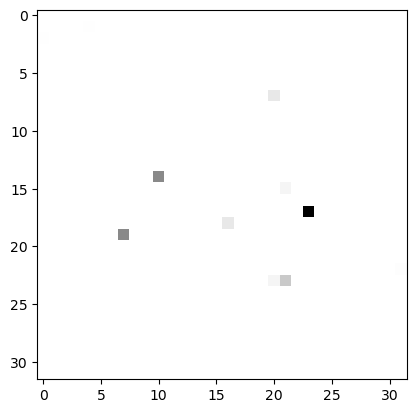

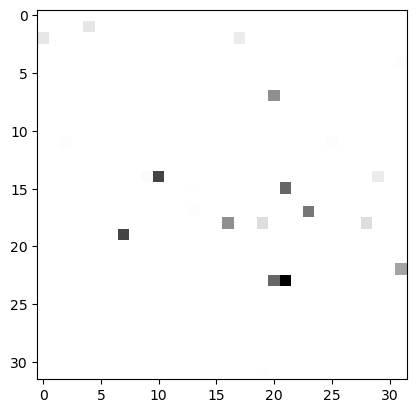

(1, 1)


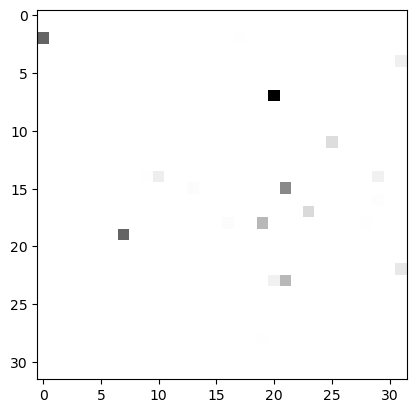

(2, 0)


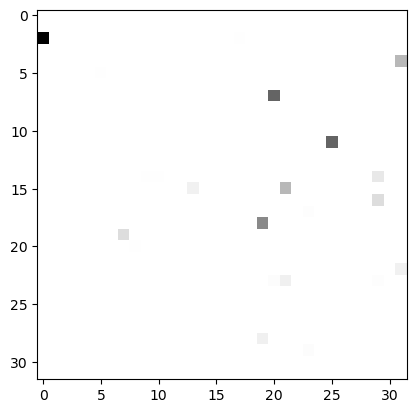

(3, 0)


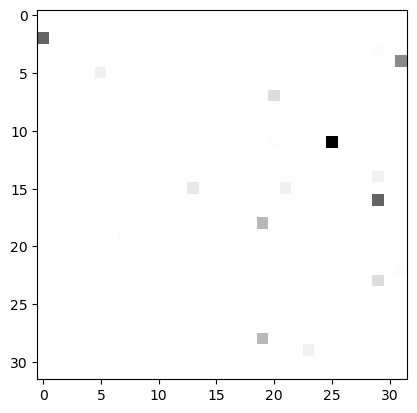

(4, 0)


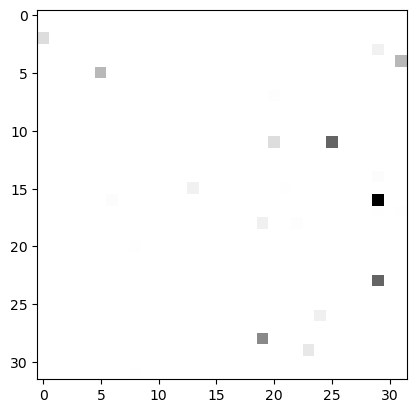

(5, 0)


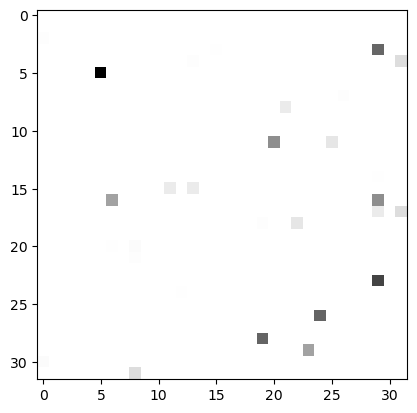

(6, 1)


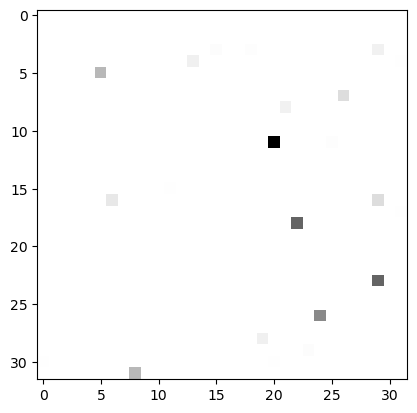

(7, 0)


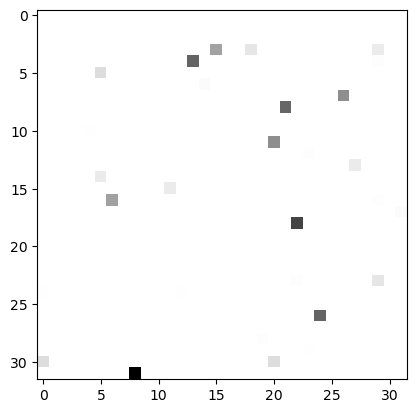

(8, 1)


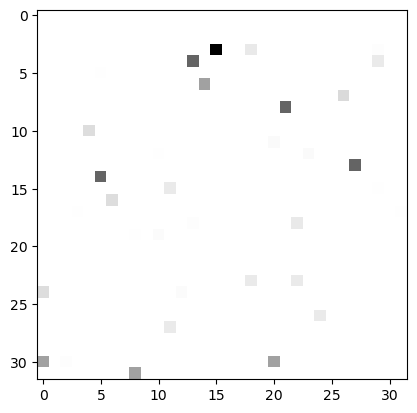

(9, 2)


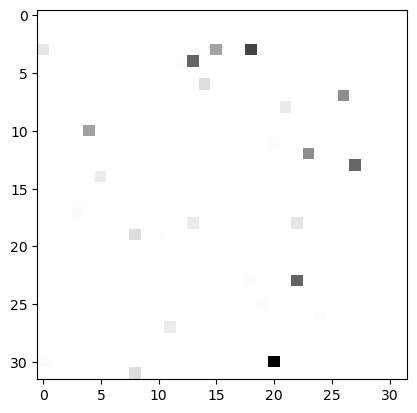

(10, 1)


In [178]:
plt.imshow(env2.reset()[0], cmap=plt.cm.binary)
plt.show()
for a in [env._get_info()['action_map'][i,i] for i in range(env_size-1)][:10]:
    plt.imshow(env2.step(a)[0], cmap=plt.cm.binary)
    plt.show()
    print(env._get_obs())

## Register the environment

In [ ]:
from gym.envs.registration import register

register(
    id='gym_examples/GridWorld-v0',
    entry_point='gym_examples.envs:GridWorldEnv',
    max_episode_steps=300,
)
